# Meme Economy Health Benchmark

### Why?
I just wanted a dumb example for this repository. So why not focus on memes. 

![](https://media.giphy.com/media/wcjtdRkYDK0sU/giphy.gif)

### Thought Process
Reddit users post on [r/MemeEconomy](https://reddit.com/r/memeeconomy) with new meme templates that have potential (`buy`) or memes that have become oversaturated (`sell`). In a healthy meme economy, we'd see more `buy` posts than `sell` posts. The ratio of buys over 

$$ health = \frac{buy}{buy + sell} $$
<br>


### Bayes Theorem
A frequentists statistician would use the above and be done. However, a Bayesian would consider a different approach. One reason would why, is the problem of identifying `buy` and `sell` posts. Below I'll naively just assign posts based on if the post has `buy` or `sell` in the title. This means that posts without either will not be considered. That makes the data for our inference a sample of the population, therefore introducing some uncertainty about our results. Bayesian statstics deals with the notion of uncertainty.
<br>

$$ P(A \mid B) = \frac{P(B \mid A) \, P(A)}{P(B)} $$
<br>

The above is Bayes law. In Bayesian Inferance, A is the parameter of our model (let's say the probability of a buy post) and B is our data. $P(B \mid A)$ is known as a liklihood and $P(A)$ our prior. Our data is a series of boolean values (1 for `buy`, 0 for `sell`), looking something like `[0,1,1,0...]`. We can think of this as essentially a coin flip. The probability distribution for a coinflip is a Bernoulli distribution $Bernoulli(p)$. p is the probability of flipping a heads, or in our case the probability of posting a `buy`. This model corresponds to our liklihood. For now, let's assume we have no prior knowledge of what p is, so we will set our prior to be $Uniform(0, 1)$. This means there is an equal chance that `p` is anything between 0 and 1. I won't explain the math behind how to compute $ P(A \mid B)$, the posterior. You can look that up online pretty easily

<br>
Below we will collect the data, and use pymc's [Markov Chain Monte Carlo(MCMC)](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo) methodology to get a propability distribution (posterior) for `p` given our data. 


In [65]:
# Let's import some useful libraries
import os
import praw
import datetime

import pymc as pm

In [66]:
# Create a Reddit Object using my API credentials and grab the Meme Economy Subreddit
reddit = praw.Reddit(client_id=os.environ.get('PYRESEARCH_REDDIT_CLIENT_ID'),
                     client_secret=os.environ.get('PYRESEARCH_REDDIT_CLIENT_SECRET'),
                     password=os.environ.get('PYRESEARCH_REDDIT_PASSWORD'),
                     user_agent='meme economy bayesian score',
                     username=os.environ.get('PYRESEARCH_REDDIT_USERNAME'),)
memes = reddit.subreddit('memeeconomy')

In [67]:
# Create a Dataset labeling posts buy or sell
has_buy = []
for submission in memes.new(limit=1000):
    if "buy" in submission.title.lower():
        has_buy.append(1)
    elif "sell" in submission.title.lower():
        has_buy.append(0)
print(sum(has_buy))
print(len(has_buy))

90
142


 [-----------------100%-----------------] 18000 of 18000 complete in 1.1 sec

/opt/conda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


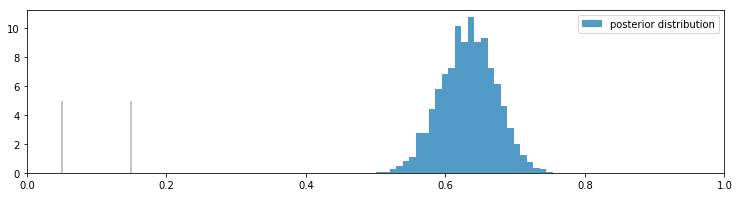

In [68]:
%matplotlib inline
from IPython.core.pylabtools import figsize
from matplotlib import pyplot as plt

# Setup Inference Network and use MCMC
prior = pm.Uniform("p", 0, 1)
obs = pm.Bernoulli("obs", prior, value=has_buy, observed=True)
model = pm.Model([obs, prior])
mcmc = pm.MCMC(model)
mcmc.sample(18000, 1000)

# Graph Posterior Distribution
figsize(12.5, 3)
p_trace = mcmc.trace("p")[:]
plt.hist(p_trace, histtype="stepfilled", normed=True, alpha=0.85, bins=30,
         label="posterior distribution", color="#348ABD")
plt.vlines([.05, .15], [0, 0], [5, 5], alpha=0.3)
plt.xlim(0, 1)
plt.legend();

In [69]:
 print("The expected probability of theta is %f" % p_trace.mean())

The expected probability of theta is 0.632499


So we end up with $p=0.632$ . That is very close to the frequentist answer of .64. This makes sense. Since we gave a uniform prior, indicating we have no prior knoweldge, MCMC will converge toward the frequentist answer. Below, I'll repeat the model, but this time, I'll compute the posterior for the first half of the data, and use the first posterior distribution as a prior in computing the second one. 

 [-----------------100%-----------------] 18000 of 18000 complete in 1.1 sec
The expected probability of theta is 0.6452019348650069 and the variance is 0.0031325760583094543


/opt/conda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


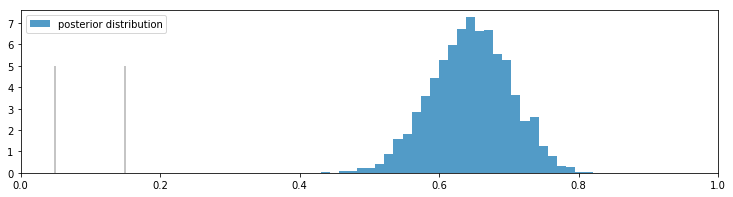

In [71]:
prior = pm.Uniform("theta", 0, 1)
obs = pm.Bernoulli("obs", prior, value=has_buy[: len(has_buy)//2], observed=True)
model = pm.Model([obs, prior])
mcmc = pm.MCMC(model)
mcmc.sample(18000, 1000)

predicted_theta = mcmc.trace('theta')[:].mean()
predicted_var = mcmc.trace('theta')[:].var()
print(f"\nThe expected probability of theta is {predicted_theta} and the variance is {predicted_var}")
figsize(12.5, 3)
p_trace = mcmc.trace("theta")[:]
plt.hist(p_trace, histtype="stepfilled", normed=True, alpha=0.85, bins=30,
         label="posterior distribution", color="#348ABD")
plt.vlines([.05, .15], [0, 0], [5, 5], alpha=0.3)
plt.xlim(0, 1)
plt.legend();

 [-----------------100%-----------------] 18000 of 18000 complete in 1.2 sec
The expected probability of theta is 0.645021


/opt/conda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


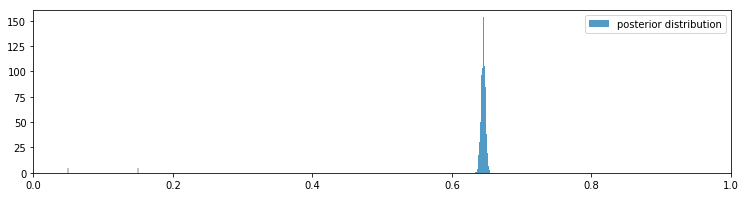

In [72]:
informed_prior = pm.Normal("theta_2", predicted_theta, 1/ (predicted_var ** 2))
obs = pm.Bernoulli("obs", informed_prior, value=has_buy[len(has_buy)//2:], observed=True)
model = pm.Model([obs, informed_prior])
mcmc = pm.MCMC(model)
mcmc.sample(18000, 1000)

print("\nThe expected probability of theta is %f" % mcmc.trace('theta_2')[:].mean())
figsize(12.5, 3)
p_trace = mcmc.trace("theta_2")[:]
plt.hist(p_trace, histtype="stepfilled", normed=True, alpha=0.85, bins=30,
         label="posterior distribution", color="#348ABD")
plt.vlines([.05, .15], [0, 0], [5, 5], alpha=0.3)
plt.xlim(0, 1)
plt.legend();

Again we get a similar answer. In the second posterior, we are far more certain of `p`. This is because our prior was a lot more certain. 